In [1]:
import sys
import os
import os.path as osp
import random
import math
#import pylab
import copy
import re
from enum import Enum
from collections import OrderedDict
from collections import namedtuple
import tensorflow as tf
from tensorflow.python.summary.summary_iterator import summary_iterator
from tensorflow.python.framework import tensor_util
import pandas as pd

import numpy as np
import pandas as pd
import scipy.stats as ss

import matplotlib.pyplot as plt
import seaborn as sns


DIV_LINE_WIDTH = 50
print(np.__version__)
print(sys.executable)
sns.set()
# pip install pandas matplotlib seaborn

1.21.5
/home/remy/anaconda3/envs/ogprocgen/bin/python


# Loading data

In [2]:
def get_config_dict(log_file_path):
    
    #open text file in read mode
    text_file = open(log_file_path, "r")

    #read whole file to a string
    txt = text_file.read()

    #close file
    text_file.close()
    
    config_str = '{'+txt.split('{')[1].split('}')[0]+'}'
    #config_str= "{'action_space_size': 15, 'num_actors': 1, 'do_consistency': False, 'use_value_prefix': True, 'off_correction': True, 'gray_scale': False, 'auto_td_steps_ratio': 0.3, 'episode_life': True, 'change_temperature': True, 'init_zero': True, 'state_norm': False, 'clip_reward': True, 'random_start': True, 'cvt_string': True, 'image_based': True, 'max_moves': 4000, 'test_max_moves': 4000, 'history_length': 400, 'num_simulations': 50, 'discount': 0.997, 'max_grad_norm': 5, 'test_interval': 20000, 'test_episodes': 300, 'value_delta_max': 0.01, 'root_dirichlet_alpha': 0.3, 'root_exploration_fraction': 0.25, 'pb_c_base': 19652, 'pb_c_init': 1.25, 'training_steps': 300000, 'last_steps': 0, 'checkpoint_interval': 100, 'target_model_interval': 200, 'save_ckpt_interval': 100000, 'log_interval': 1000, 'vis_interval': 1000, 'start_transitions': 8000, 'total_transitions': 10000000, 'transition_num': 1, 'batch_size': 256, 'num_unroll_steps': 5, 'td_steps': 5, 'frame_skip': 1, 'stacked_observations': 16, 'lstm_hidden_size': 512, 'lstm_horizon_len': 5, 'reward_loss_coeff': 1, 'value_loss_coeff': 0.25, 'policy_loss_coeff': 1, 'consistency_coeff': 0, 'device': 'cuda', 'debug': False, 'seed': 1, 'value_support': <core.config.DiscreteSupport object at 0x14fe20f85ed0>, 'reward_support': <core.config.DiscreteSupport object at 0x14fe20f85f10>, 'use_adam': True, 'weight_decay': 0.0001, 'momentum': 0.9, 'lr_warm_up': 0.01, 'lr_warm_step': 3000, 'lr_init': 0.2, 'lr_decay_rate': 0.1, 'lr_decay_steps': 300000, 'mini_infer_size': 64, 'priority_prob_alpha': 0.6, 'priority_prob_beta': 0.4, 'prioritized_replay_eps': 1e-06, 'image_channel': 3, 'proj_hid': 1024, 'proj_out': 1024, 'pred_hid': 512, 'pred_out': 1024, 'batch_queue_size': 20, 'batch_queue_thr': 15, 'mcts_queue_size': 25, 'mcts_queue_thr': 18, 'num_levels_per_env': 2, 'bn_mt': 0.1, 'blocks': 1, 'channels': 64, 'reduced_channels_reward': 16, 'reduced_channels_value': 16, 'reduced_channels_policy': 16, 'resnet_fc_reward_layers': [32], 'resnet_fc_value_layers': [32], 'resnet_fc_policy_layers': [32], 'downsample': True, 'env_name': 'procgen:procgen-coinrun-v0', 'obs_shape': (48, 64, 64), 'case': 'procgen', 'amp_type': 'torch_amp', 'use_priority': True, 'use_max_priority': True, 'cpu_actor': 14, 'gpu_actor': 20, 'p_mcts_num': 250, 'use_root_value': False, 'use_augmentation': False, 'auto_td_steps': 90000.0, 'revisit_policy_search_rate': 0.99, 'model_dir': '/gpfsscratch/rech/imi/uxo14qj/storage/procgen/26-05_adamW_02_nocons_fstack16/procgen:procgen-coinrun-v0/seed=1/Thu May 26 20:12:14 2022/model'}"
    # mask pointers to avoid eval errors
    config_str = re.sub('<[a-zA-Z0-9. ]*>', "'ptr_removed'", config_str, count=0, flags=0)
    
    return eval(config_str)

def simplify(name):
    return name.split('/')[1]

def tf_event_to_dict(eventfile):
    # Add keys to this list to extract more data
    keys_to_load = ["train/mean_score","train/std_score","Train/episodes_collected","Train/transitions_collected","Train/replay_buffer_len","Train/total_node_num","Train/lr"]
    data_dict = {simplify(key):[] for key in keys_to_load}
    for i,event in enumerate(summary_iterator(eventfile)):
        for value in event.summary.value:
            if simplify(value.tag) in data_dict.keys():
                data_dict[simplify(value.tag)].append(value.simple_value)

    # convert to numpy float32    
    for key in data_dict.keys():
        data_dict[key] = np.array(data_dict[key], dtype=np.float32)

    return data_dict

def get_baselines_run_logs(root, exp_idx, units, condition=None):
    '''
        Load logs produced by OpenAI Baselines students.
    '''
    condition1 = condition or 'exp'
    condition2 = condition1 + '-' + str(exp_idx)
    if condition1 not in units:
        units[condition1] = 0
    unit = units[condition1]
    units[condition1] += 1

    try:
        exp_data = pd.read_csv(os.path.join(root, 'progress.csv'))
    except Exception as err:
        print(err)
        print('no progress data, aborting')
        return None

    exp_data.insert(len(exp_data.columns), 'Unit', unit)
    exp_data.insert(len(exp_data.columns), 'Condition1', condition1)
    exp_data.insert(len(exp_data.columns), 'Condition2', condition2)
    exp_data.insert(len(exp_data.columns), 'training return', exp_data['eprewmean'])
    if 'eval_eprewmean' in exp_data:
        exp_data.insert(len(exp_data.columns), 'evaluation return', exp_data['eval_eprewmean'])

    data_dict = exp_data.to_dict("list")
    data_dict['total timesteps'] = exp_data["misc/total_timesteps"]
    splitted_name = root.split("_")
    seed = splitted_name[len(splitted_name) - 1].replace('s', '')
    data_dict['config'] = {
        "seed": seed
    }

    return data_dict

def get_run_logs(logdir, book_keeping_keys='*', min_len=4):
    """
        Recursively look through logdir for output files produced by experiments.
        Assumes that any file "progress.txt/csv" is a valid hit.
    """
    exp_idx = 0
    units = dict()
    datasets = []
    for root, _, files in os.walk(logdir):
        data_dict = None
        if 'progress.txt' in files: # Spinup
            print("Reading spinup run...")
            data_dict = get_spinup_run_logs(root, exp_idx, units)
        elif 'progress.csv' in files: # OpenAI Baselines
            print("Reading baselines run...")
            data_dict = get_baselines_run_logs(root, exp_idx, units)

        exp_idx += 1
        if data_dict is None:
            continue

        run_name = root[13:]

        nb_epochs = len(data_dict['total timesteps'])
        print('{} -> {}'.format(run_name, nb_epochs))
        if nb_epochs >= min_len:
            if 'env_params_save.pkl' in files:
                try:
                    env_params_dict = pickle.load(open(os.path.join(root, 'env_params_save.pkl'), "rb"))
                    for k, v in env_params_dict.items():
                        if book_keeping_keys == '*' or k in book_keeping_keys:
                            data_dict[k] = v
                except EOFError as err:
                    print(err)
                    print('Corrupted save, ignoring {}'.format(root[-1])) #data_dict['config']['seed']))
                except pickle.UnpicklingError as err:
                    print(err)
                    print('Corrupted save, ignoring {}'.format(root[-1:]))
                    #continue
            datasets.append(data_dict)
    return datasets

            
# def get_run_logs(logdir, book_keeping_keys='*', min_len=2120, min_transitions=15*1e6):#12*1e6):#80*1000):#=3 * 1e6):#80*1000):
#     """
#         Recursively look through logdir for output files produced by experiments.
#         Assumes that any file "progress.txt/csv" is a valid hit.
#         returns None if no valid run was found
#     """
#     exp_idx = 0
#     units = dict()
#     expe_dict = {'data':[]}
    
#     add_config = False
#     for root, _, files in os.walk(logdir):
#         data_dict = None
#         for f in files:
#             if 'events.out.tfevents' in f:
#                 data = tf_event_to_dict(root+'/'+f)
#                 nb_transitions = None if len(data['transitions_collected']) == 0 else data['transitions_collected'][-1]
#                 if len(data['mean_score'])>min_len and nb_transitions and nb_transitions > min_transitions:
#                     #if data['transitions_collected'][-1] > min_transitions:
#                     #print(nb_transitions)
#                     expe_dict['data'].append(data)
#                     add_config = True
#                 else: 
#                     print('discarding seed with {} test datapoints and {} env steps '.format(len(data['mean_score']), nb_transitions))
                
#             if 'train.log' in f and add_config:  # WARNING assumes config is same for each seed
#                 expe_dict['data'][-1]['config'] = get_config_dict(root+'/'+f)
#                 add_config = False
#     if len(expe_dict['data']) == 0:
#         return None
#     else:
#         return expe_dict

def add_test_steps(expe_dict):
    """
       Reconstruct list of when tests were performed in training steps (true values are slightly off)
    """
    for run_data in expe_dict['data']:
        test_interval = run_data['config']['test_interval']
        nb_tests =len(run_data['mean_score'])
        test_steps = [test_interval * i for i in range(nb_tests)]
        run_data['test_steps'] = test_steps
    
    

def get_datasets(rootdir, name_filter=None, rename_labels=False):
    """
        Loads results of experiments.
 
        Results to load can be filtered by their name and each experiment can be associated to a label (usually ACL method's name)
 
        :param rootdir: Directory containing experiments to load (do not forget '/' at the end of the path)
        :param name_filter: String experiments to load must contain
        :param rename_labels: If True, each experiment will be associated to a label (see below). Labels are the names that will appear in plots.
        :type rootdir: str
        :type name_filter: str (or None)
        :type rename_labels: boolean
    """
    global default_colors_palette
    _, models_list, _ = next(os.walk(rootdir))
    print(models_list)
    for dir_name in models_list.copy():
        if "ignore" in dir_name:
            models_list.remove(dir_name)
        if name_filter is not None and name_filter not in dir_name:
            models_list.remove(dir_name)
            
    # setting per-model type colors
    if len(per_model_colors) == 0 and  len(models_list) > len(default_colors_palette):
        default_colors_palette = sns.color_palette("hls", len(models_list))
        
    for i,m_name in enumerate(models_list):
        
        print("extracting data for {}...".format(m_name))
        m_id = m_name
        models_saves[m_id] = OrderedDict()
        models_saves[m_id] = get_run_logs(rootdir+m_name, book_keeping_keys=['env_test_rewards'], min_len=0)
        if not models_saves[m_id]:
            print(f"{m_id} all seeds unfitting, removing run")
            del models_saves[m_id]
            continue
        #add_test_steps(models_saves[m_id])
             
        for m_type, m_color in per_model_colors.items():
            if m_type in m_name:
                colors[m_name] = m_color
        if m_name not in colors:
            colors[m_name] = default_colors_palette[i]
        
        
        #models_saves[m_id]['config'] = get_config(
        print("done")
        if m_name not in labels:
            if not rename_labels:
                labels[m_name] = m_name
            else:
                ##### MODIFY THIS IF YOU ADD A NEW METHOD #####
                if 'ADR' in m_name:
                    labels[m_name] = 'ADR'
                elif 'ALP-GMM' in m_name:
                    labels[m_name] = 'ALP-GMM'
                elif 'Random' in m_name:
                    labels[m_name] = 'Random'
                elif 'Covar-GMM' in m_name:
                    labels[m_name] = 'Covar-GMM'
                elif 'RIAC' in m_name:
                    labels[m_name] = 'RIAC'
                elif 'GoalGAN' in m_name:
                    labels[m_name] = 'GoalGAN'
                elif 'Self-Paced' in m_name:
                    labels[m_name] = 'Self-Paced'
                elif 'Setter-Solver' in m_name:
                    labels[m_name] = 'Setter-Solver'
                elif 'UPPER_BASELINE' in m_name:
                    labels[m_name] = 'UPPER_BASELINE'
                else:
                    labels[m_name] = m_name
                ##### MODIFY THIS IF YOU ADD A NEW METHOD #####
                
labels = OrderedDict()
default_colors_palette = sns.color_palette('colorblind') + ["pink", "cyan"]
print(len(default_colors_palette))
##### MODIFY THIS IF YOU ADD A NEW METHOD #####
per_model_colors = OrderedDict() # Set it to empty if you want one color per experiment instead of one color per ACL method
#per_model_colors = OrderedDict([('alpgmm', default_colors_palette[0])])

# per_model_colors = OrderedDict([('ALP-GMM', default_colors_palette[0]),
#                                 ('Covar-GMM', default_colors_palette[1]),
#                                 ('ADR', default_colors_palette[2]),
#                                 ('Random', default_colors_palette[3]),
#                                 ('RIAC', default_colors_palette[4]),
#                                 ('GoalGAN', default_colors_palette[9]),
#                                 ('Self-Paced', default_colors_palette[6]),
#                                 ('Setter-Solver', default_colors_palette[7]),
#                                 ('UPPER_BASELINE', default_colors_palette[5])])
##### MODIFY THIS IF YOU ADD A NEW METHOD #####

models_saves = OrderedDict()
colors = OrderedDict()

##### MODIFY THIS TO POINT TO YOUR DATA FOLDER #####
data_folder = "/home/remy/projects/postdoc/og_procgen/results/"
##### MODIFY THIS TO POINT TO YOUR DATA FOLDER #####

get_datasets(data_folder, rename_labels=False, name_filter="PPO_LOCA5")
# get_datasets(data_folder, rename_labels=False, name_filter="ADR") # You can also add filters

# order runs for legend order as in per_models_colors, with corresponding colors
if len(per_model_colors) > 0:
    ordered_labels = OrderedDict()
    for teacher_type in per_model_colors.keys():
        for k,v in labels.items():
            if teacher_type in k:
                ordered_labels[k] = v
    labels = ordered_labels

12
['06-08_PPO_LOCA3_env_name_locacoinrun_distribution_mode_easy_phase_3_len_35_ent_.02', '29-06_ogpgentests_env_name_starpilot_distribution_mode_easy_0', '24-08_PPO_LOCA3l2reg_env_name_locacoinrun_distribution_mode_easy_l2_coef_0.0001', '24-08_PPO_LOCA5l2regTESTonly3_env_name_locacoinrun_distribution_mode_easy_phase_1_len_0_phase_2_len_0_phase_3_len_15', '30-07_fixfullLOCA_env_name_locacoinrun_distribution_mode_easy', '05-08_PPO_LOCA3_env_name_locacoinrun_distribution_mode_easy_phase_3_len_35_normalize_rewards', '04-08_PPO_LOCA3_env_name_locacoinrun_distribution_mode_easy_phase_2_len_2', '28-07_loca_env_name_locacoinrun_distribution_mode_easy_normalize_rewards', '24-08_PPO_LOCA4NOl2reg_env_name_locacoinrun_distribution_mode_easy_phase_3_len_5', '30-07_fix2fullLOCA_env_name_locacoinrun_distribution_mode_easy', '31-07_PPO_LOCA2_env_name_locacoinrun_distribution_mode_easy', '06-08_PPO_LOCA3_env_name_locacoinrun_distribution_mode_easy_phase_3_len_35_ent_.001', '29-06_ogpgentests_env_name_

# Plot utils

In [3]:
# QUICK END PERF STATS, NO CURVES


 # name pre-processing
def preprocess_label(label):
    label = label[6:]
    label = label.replace('_env_args_','')
    label = label.replace('ame_coinrun_distribution_mode_easy_num_envs_1_nsteps_16384','EZcrun_1env_nsteps16384')
    #print(label)
    return label

metric = "training return"

max_steps = 0
for i,m_id in enumerate(models_saves.keys()):
    # if not "len_35" in m_id:
    #     continue
    #print(models_saves[m_id])
    runs_data = models_saves[m_id]
    ys = []
    nb_seeds = len(runs_data)
    seeds=[]
    env_steps = []
    time_elapsed = []
    if nb_seeds > 0:
        for run in runs_data:
            data = run[metric]
            if len(data) == 0:  # the seed failed, let's ignore it
                print('ignoring')
                continue
            seeds.append(run["config"]["seed"])
            env_steps.append(run['total timesteps'] / 1000000)
            time_elapsed.append(run['misc/time_elapsed'][-1])
            ys.append(data)
    
    min_len = min([len(y) for y in ys])
    train_steps = runs_data[0]['misc/nupdates'][:min_len]
    mean_env_steps = np.mean([e[min_len-1] for e in env_steps])
    
    ys_same_len = np.ma.empty((len(ys), min_len))
    ys_same_len.mask = True
    for i in range(len(ys)):
        y = ys[i]
        for j in range(min_len):
            ys_same_len[i, j] = y[j]
    train_steps = [e/1000 for e in train_steps]


    stds = ys_same_len.std(axis=0)
    means = ys_same_len.mean(axis=0)


    last_ys=[seed_ys[-1] for seed_ys in ys_same_len]
    
    # computes stats^
    percentiles = np.percentile(last_ys,[25,50,75])
    max_index = np.argmax(last_ys)
    max_perf = last_ys[max_index]
    max_perf_seed = seeds[max_index]
    label = preprocess_label(m_id)
    label_size = len(label)
    if label_size < 50:
        for i in range(50-label_size):
            label += ' '

    print("{}: {}k(e_steps:{}M), {} +- {}, end_perfs:{}(#seeds:{}) time:{}".format(label[50:],
                                                           np.round(train_steps[-1],6),
                                                           np.round(mean_env_steps,2),                              
                                                           np.round(means[-1],2),
                                                           np.round(np.std(last_ys),2),
                                                           np.round(last_ys,1),
                                                           len(last_ys),
                                                           np.round(np.mean(time_elapsed),1)))
    
        # print("{}: {}k(e_steps:{}M), {} +- {}, perc:{}, max:{} seed {}(tot:{})".format(label,
        #                                                    np.round(train_steps[-1],6),
        #                                                    np.round(min_env_steps,2),                              
        #                                                    np.round(means[-1],2),
        #                                                    np.round(np.std(last_ys),2),
        #                                                    np.round(percentiles,2),
        #                                                    np.round(max_perf,2),
        #                                                    max_perf_seed,
        #                                                    len(last_ys)))

ibution_mode_easy_phase_1_len_0_phase_2_len_0_phase_3_len_15: 0.915k(e_steps:14.99M), 1.62 +- 0.04, end_perfs:[1.6 1.5 1.6 1.7](#seeds:4) time:3804.4
ode_easy_l2_coef_0.00001_phase_3_len_20: 1.831k(e_steps:30.0M), 1.43 +- 0.25, end_perfs:[1.  1.6 1.4 1.6](#seeds:4) time:7342.5
ode_easy_l2_coef_0.005_phase_3_len_20: 1.831k(e_steps:30.0M), 0.7 +- 0.05, end_perfs:[0.8 0.7 0.7 0.7](#seeds:4) time:6298.4
ode_easy_l2_coef_0.001_phase_3_len_20: 1.831k(e_steps:30.0M), 1.38 +- 0.28, end_perfs:[1.5 0.9 1.6 1.5](#seeds:4) time:7382.2
_mode_easy_phase_3_len_20: 1.831k(e_steps:30.0M), 1.42 +- 0.32, end_perfs:[0.9 1.5 1.6 1.7](#seeds:4) time:7239.8
ode_easy_l2_coef_0.0001_phase_3_len_20: 1.831k(e_steps:30.0M), 1.66 +- 0.02, end_perfs:[1.6 1.7 1.6 1.6](#seeds:4) time:7472.3


In [6]:
class Statistical_tests_enum(Enum):
    """
        Statistical test type.
 
        MULTI_STEP: T-test must be computed between the two distributions at each time step
        MULTI_STEP: T-test must be computed between the two distributions only at the last time step
    """
    NONE = 0
    MULTI_STEP = 1
    LAST_STEP = 2
    
def plot_with_shade(subplot_nb, ax,x,y,err,color,shade_color,label,
                  legend=False, leg_size=30, leg_loc='best', title=None,
                  ylim=[0,100], xlim=[0,40], leg_args={}, leg_linewidth=8.0, linewidth=7.0,
                  ticksize=30, y_label='% Mastered env', label_size=30):
    """
        Plot a curve along with its error (shade).
 
        :param subplot_nb: Index in multi-plots figure
        :param ax: Matplotlib axis
        :param x: List of x positions
        :param y: List associated y
        :param color: Curve color 
        :param shade_color: Shade color
        :param label: Label name of the curve
        :param legend: Whether legend should be printed
        :param leg_size: Legend size
        :param leg_loc: Legend position
        :param title: Plot title
        :param ylim: Limits of the y axis
        :param xlim: Limits of the x axis
        :param leg_args: Matplotlib legend arguments
        :param leg_linewidth: Legend's line width
        :param linewidth: Curve's width
        :param ticksize: Axis tick size
        :param y_label: Y axis label
        :param label_size: Label size in legend
    """
    ax.locator_params(axis='x', nbins=5)
    ax.locator_params(axis='y', nbins=5)
    ax.tick_params(axis='both', which='major', labelsize=ticksize)
    ax.plot(x,y, color=color, label=label,linewidth=linewidth)
    ax.fill_between(x,y-err,y+err,color=shade_color,alpha=0.2)
    if legend:
        leg = ax.legend(loc=leg_loc, fontsize=leg_size, **leg_args) #34
        for legobj in leg.legendHandles:
            legobj.set_linewidth(leg_linewidth)
    ax.set_xlabel('Training steps (millions)', fontsize=label_size)
    if subplot_nb == 0:
        ax.set_ylabel(y_label, fontsize=label_size)
    ax.set_xlim(xmin=xlim[0],xmax=xlim[1])
    ax.set_ylim(bottom=ylim[0],top=ylim[1])
    if title:
        ax.set_title(title, fontsize=22)

def plot_all_and_median(subplot_nb, ax,x,ys,color,label,
                         y_min=None,y_max=None, legend=False, title=None, x_max=20, y_label='% Mastered env'):
    """
        Plot curves along with their median.
 
        :param subplot_nb: Index in multi-plots figure
        :param ax: Matplotlib axis
        :param x: List of x positions
        :param y: List associated ys
        :param color: Curve color 
        :param label: Label name of the curve
        :param y_min: Minimum of the y axis
        :param y_max: Maximum of the y axis
        :param legend: Whether legend should be printed
        :param title: Plot title
        :param x_max: Maximum of the x axis
        :param y_label: Y axis label
    """
    
    ax.locator_params(axis='x', nbins=5)
    ax.locator_params(axis='y', nbins=5)
    ax.tick_params(axis='both', which='major', labelsize=30)
    min_len = 999999
    median = np.median(ys, axis=0)
    for k,y in enumerate(ys):
        ax.plot(x[0:min_len],y, color=color, linewidth=1.5, alpha=0.5)
    ax.plot(x[0:min_len],median, color=color, linewidth=7 , label=label)
    if legend:
        leg = ax.legend(loc='best', fontsize=25)
    ax.set_xlabel('Million steps', fontsize=18)
    if subplot_nb == 0:
        ax.set_ylabel(y_label, fontsize=18)
    ax.set_xlim(xmin=0,xmax=x_max)
    if y_min is not None:
        ax.set_ylim(bottom=y_min,top=y_max)
    else:
        ax.set_ylim(top=100)
    if title:
        ax.set_title(title, fontsize=22)

# Simple plotting function

In [7]:
def plot_curves(agent_type, plot_type='shade', metric='training return', legend=True, y_min=0, y_max=100, x_max=10, leg_size=20, leg_loc='best', new_labels=None,
                allow_different_sizes=False, _ax=None, welch=Statistical_tests_enum.NONE, welch_baseline='all', welch_p_threshold=0.05, welch_step_freq=1):
    """
         Plot curves of experiments whose name matches `agent_type` regex.
 
        :param agent_type: Regex filtering experiments to show
        :param plot_type: 'shade' (mean + std) OR 'shade_se' (mean + standard error of the mean) OR 'all_and_median' (all curves + median)
        :param metric: Metric to plot
        :param legend: Whether legend should be printed
        :param y_min: Minimum of the y axis
        :param y_max: Maximum of the y axis
        :param x_max: Maximum of the x axis
        :param leg_size: Legend size
        :param leg_loc: Legend position
        :param new_labels: Labels replacing the labels loaded when getting experients' logs in plots
        :param allow_different_sizes: Allow curves to have different size (otherwise stop all curves at the length of the shortest)
        :param _ax: Matplotlib axis
        :param welch: Whether statistical tests should be computed (must be a `Statistical_tests_enum` value)
        :param welch_baseline: Baseline every method should be compared to. If all combinations must be computed use 'all'
        :param welch_p_threshold: P-value threshold to reject null hypothesis
        :param welch_step_freq: Welch's test will be calculated every `welch_step_freq` steps if MULTI_STEP
    """
    if _ax is None:
        f, ax = plt.subplots(1,1,figsize=(12,12))
    else:
        ax = _ax
    ys_for_weclh = {}
    episodes_per_experiment = {}
    max_y = -1
    anything_token = "*"
    anything_pattern = "[a-zA-z0-9\-.:]*"
    agent_type_regex_pattern = agent_type.replace(anything_token, anything_pattern)
    print(agent_type_regex_pattern)
    regex = re.compile(agent_type_regex_pattern)
    _labels = new_labels if new_labels is not None else labels
    for i,(m_id,label) in enumerate(_labels.items()):
        print(m_id)
        if regex.match(m_id):
            print(m_id)
            runs_data = models_saves[m_id]
            ys = []
            episodes = []
            nb_seeds = len(runs_data)
            if nb_seeds > 0:
                for run in runs_data:  
                    data = run[metric]
                    if len(run['total timesteps']) > len(episodes):
                        episodes = np.array(run['total timesteps'])
                    ys.append(data)
                #print(ys)
                if not allow_different_sizes:
                    #clean data in case an expe has seeds with varying epoch number    
                    min_len = 999999
                    for y in ys:
                        if len(y) < min_len:
                            min_len = len(y)
                    ys_same_len = np.empty((len(ys), min_len))
                    for i in range(len(ys)):
                        y = ys[i]
                        for j in range(min_len):
                            ys_same_len[i, j] = y[j]
                    episodes = episodes[0:min_len]
                else:
                    full_len = max([len(y) for y in ys])
                    ys_same_len = np.ma.empty((len(ys), full_len))
                    ys_same_len.mask = True
                    for i in range(len(ys)):
                        y = ys[i]
                        for j in range(len(y)):
                            ys_same_len[i, j] = y[j]
                episodes = [e/1000000 for e in episodes]
                episodes_per_experiment[m_id] = episodes
                
                if ys_same_len.size > 0:
                    if welch != Statistical_tests_enum.NONE:
                        ys_for_weclh[m_id] = ys_same_len

                    if plot_type in ["shade", "shade_se"]:
                        stds = ys_same_len.std(axis=0)
                        if plot_type == "shade_se":
                            stds = stds / math.sqrt(nb_seeds)
                        means = ys_same_len.mean(axis=0)
                        max_y = max(max_y, max(means + stds))
                        plot_with_shade(0, ax, episodes, means, stds, colors[m_id],
                                        colors[m_id], label, leg_loc=leg_loc, y_label=metric, leg_args={"frameon":False},
                                        legend=legend, ylim=[y_min,y_max], xlim=[0,x_max], leg_size=leg_size,
                                        ticksize=40, label_size=40)
                    elif plot_type == "all_and_median":
                        plot_all_and_median(0, ax, episodes,ys_same_len,colors[m_id],label,
                                            title="{}".format(agent_type), legend=legend, x_max=x_max,
                                            y_min=y_min, y_max=y_max, y_label=metric)
    
    if welch != Statistical_tests_enum.NONE:
        # Get baseline(s) to compare with
        if welch_baseline == 'all':
            results_to_compare = ys_for_weclh.keys()
        else:
            if welch_baseline not in ys_for_weclh: raise Exception("Unrecognized baseline experiment name for welch's test")
            results_to_compare = [welch_baseline]
        
        i = 0  
        for expe in ys_for_weclh:
            j = 0
            for expe_2 in results_to_compare:
                if expe != expe_2:
                    if welch == Statistical_tests_enum.MULTI_STEP:
                        ttest_results, maxs = get_multistep_welch(ys_for_weclh[expe], ys_for_weclh[expe_2])
                        k = 0
                        max_val = max_y if max_y > 0 else max(maxs)
                        for ttest in ttest_results:
                            if (k+1) % welch_step_freq == 0 and ttest[1] < welch_p_threshold:
                                ax.plot(episodes_per_experiment[expe][k], max_val + 2*(i+j) + 2, 
                                        '*', markersize=20, c=colors[expe])
                            k += 1
                    elif welch == Statistical_tests_enum.LAST_STEP:
                        last_step = min(ys_for_weclh[expe].shape[1], ys_for_weclh[expe_2].shape[1]) - 1
                        ttest_result = get_simple_welch(ys_for_weclh[expe][:,last_step], ys_for_weclh[expe_2][:,last_step])
                        if ttest_result[1] < welch_p_threshold:
                            ax.plot(episodes_per_experiment[expe][-1] + 0.5, ys_for_weclh[expe].mean(axis=0)[-1], 
                                    '*', markersize=20, c=colors[expe])
                    else:
                        raise Exception("Unrecognized statistical test.")
                    j += 1
                                                    
            if welch == Statistical_tests_enum.MULTI_STEP and welch_baseline == 'all' and len(ys_for_weclh) / 2 == i + 1:
                break
            i += 1
                    

    plt.tight_layout()
    
    savefile_path = 'graphics/{0}_{1}_{2}.png'.format(agent_type.replace('*', '[]').replace('|', ','), plot_type, metric)
    if _ax is None:
        f.savefig(savefile_path, bbox_inches='tight')
    else:
        return savefile_path

[a-zA-z0-9\-.:]*
24-08_PPO_LOCA5l2regTESTonly3_env_name_locacoinrun_distribution_mode_easy_phase_1_len_0_phase_2_len_0_phase_3_len_15
24-08_PPO_LOCA5l2regTESTonly3_env_name_locacoinrun_distribution_mode_easy_phase_1_len_0_phase_2_len_0_phase_3_len_15
24-08_PPO_LOCA5l2reg_env_name_locacoinrun_distribution_mode_easy_l2_coef_0.00001_phase_3_len_20
24-08_PPO_LOCA5l2reg_env_name_locacoinrun_distribution_mode_easy_l2_coef_0.00001_phase_3_len_20
24-08_PPO_LOCA5l2reg_env_name_locacoinrun_distribution_mode_easy_l2_coef_0.005_phase_3_len_20
24-08_PPO_LOCA5l2reg_env_name_locacoinrun_distribution_mode_easy_l2_coef_0.005_phase_3_len_20
24-08_PPO_LOCA5l2reg_env_name_locacoinrun_distribution_mode_easy_l2_coef_0.001_phase_3_len_20
24-08_PPO_LOCA5l2reg_env_name_locacoinrun_distribution_mode_easy_l2_coef_0.001_phase_3_len_20
24-08_PPO_LOCA5NOl2reg_env_name_locacoinrun_distribution_mode_easy_phase_3_len_20
24-08_PPO_LOCA5NOl2reg_env_name_locacoinrun_distribution_mode_easy_phase_3_len_20
24-08_PPO_LOCA5l2

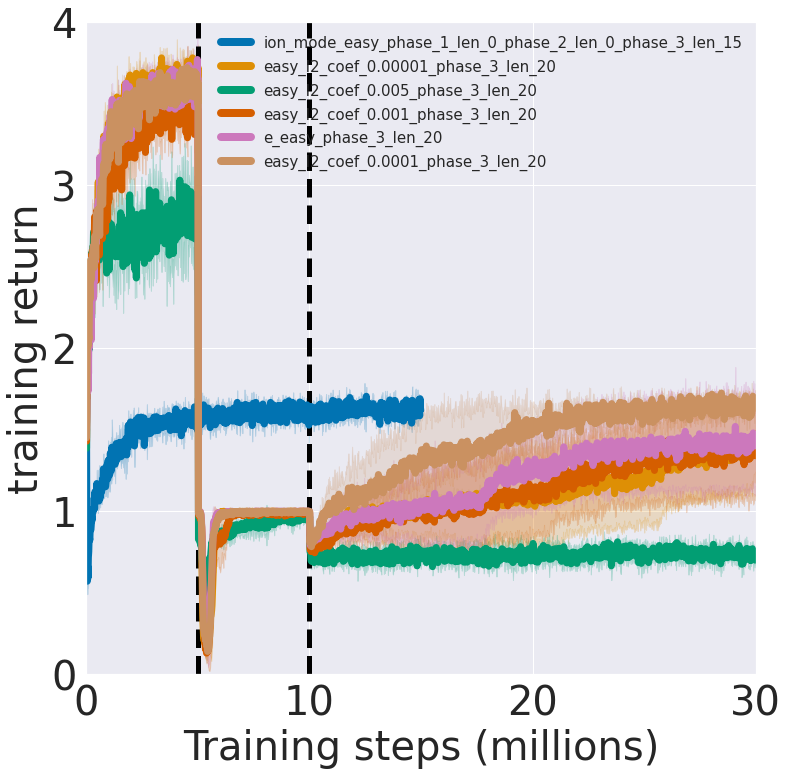

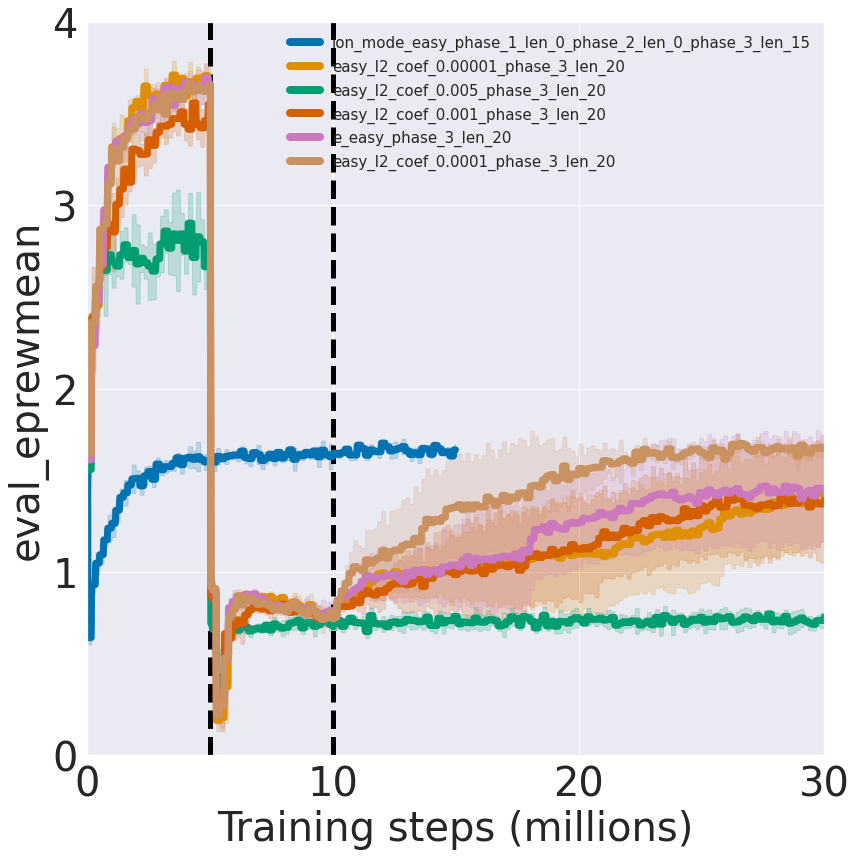

In [12]:
new_labels = {}
new_labels = {}
for m_id in models_saves.keys():
    new_labels[m_id] = m_id[60:]
    
f1, ax1 = plt.subplots(1,1,figsize=(12,12))
plt.axvline(x=5, c='black', ls='--', lw=5)
plt.axvline(x=10, c='black', ls='--', lw=5)
f3, ax2 = plt.subplots(1,1,figsize=(12,12))
plt.axvline(x=5, c='black', ls='--', lw=5)
plt.axvline(x=10, c='black', ls='--', lw=5)
#query = "(?:*ent\_\.0*|05-08*)"
query = "*"
f1.savefig(plot_curves(query, _ax = ax1, plot_type="shade", allow_different_sizes=False, x_max=30, y_max=4, new_labels=new_labels, leg_size=15, welch=Statistical_tests_enum.NONE,))
f3.savefig(plot_curves(query, _ax = ax2, metric="eval_eprewmean", plot_type="shade", allow_different_sizes=False, x_max=30, y_max=4, new_labels=new_labels, leg_size=15, welch=Statistical_tests_enum.NONE,))

#plot_curves("*starpilot*", plot_type="shade", allow_different_sizes=False, x_max=11, y_max=40, new_labels=new_labels, leg_size=10, welch=Statistical_tests_enum.NONE,)
#plot_curves("*starpilot*", plot_type="shade", metric='misc/time_elapsed', allow_different_sizes=False, x_max=None, y_max=None, new_labels=new_labels, leg_size=10, welch=Statistical_tests_enum.NONE,)

[a-zA-z0-9\-.:]*bigfish[a-zA-z0-9\-.:]*
21-06_EffMuz_fstack4_use_adam_lr_0.01_env_procgen:procgen-bigfish-v0
[a-zA-z0-9\-.:]*bossfight[a-zA-z0-9\-.:]*
21-06_EffMuz_fstack4_use_adam_lr_0.01_env_procgen:procgen-bossfight-v0
[a-zA-z0-9\-.:]*caveflyer[a-zA-z0-9\-.:]*
21-06_EffMuz_fstack4_use_adam_lr_0.01_env_procgen:procgen-caveflyer-v0
[a-zA-z0-9\-.:]*chaser[a-zA-z0-9\-.:]*
21-06_EffMuz_fstack4_use_adam_lr_0.01_env_procgen:procgen-chaser-v0
[a-zA-z0-9\-.:]*climber[a-zA-z0-9\-.:]*
21-06_EffMuz_fstack4_use_adam_lr_0.01_env_procgen:procgen-climber-v0
[a-zA-z0-9\-.:]*coinrun[a-zA-z0-9\-.:]*
21-06_EffMuz_fstack4_use_adam_lr_0.01_env_procgen:procgen-coinrun-v0
[a-zA-z0-9\-.:]*dodgeball[a-zA-z0-9\-.:]*
21-06_EffMuz_fstack4_use_adam_lr_0.01_env_procgen:procgen-dodgeball-v0
[a-zA-z0-9\-.:]*fruitbot[a-zA-z0-9\-.:]*
21-06_EffMuz_fstack4_use_adam_lr_0.01_env_procgen:procgen-fruitbot-v0
[a-zA-z0-9\-.:]*heist[a-zA-z0-9\-.:]*
21-06_EffMuz_fstack4_use_adam_lr_0.01_env_procgen:procgen-heist-v0
[a-zA-z0-9\

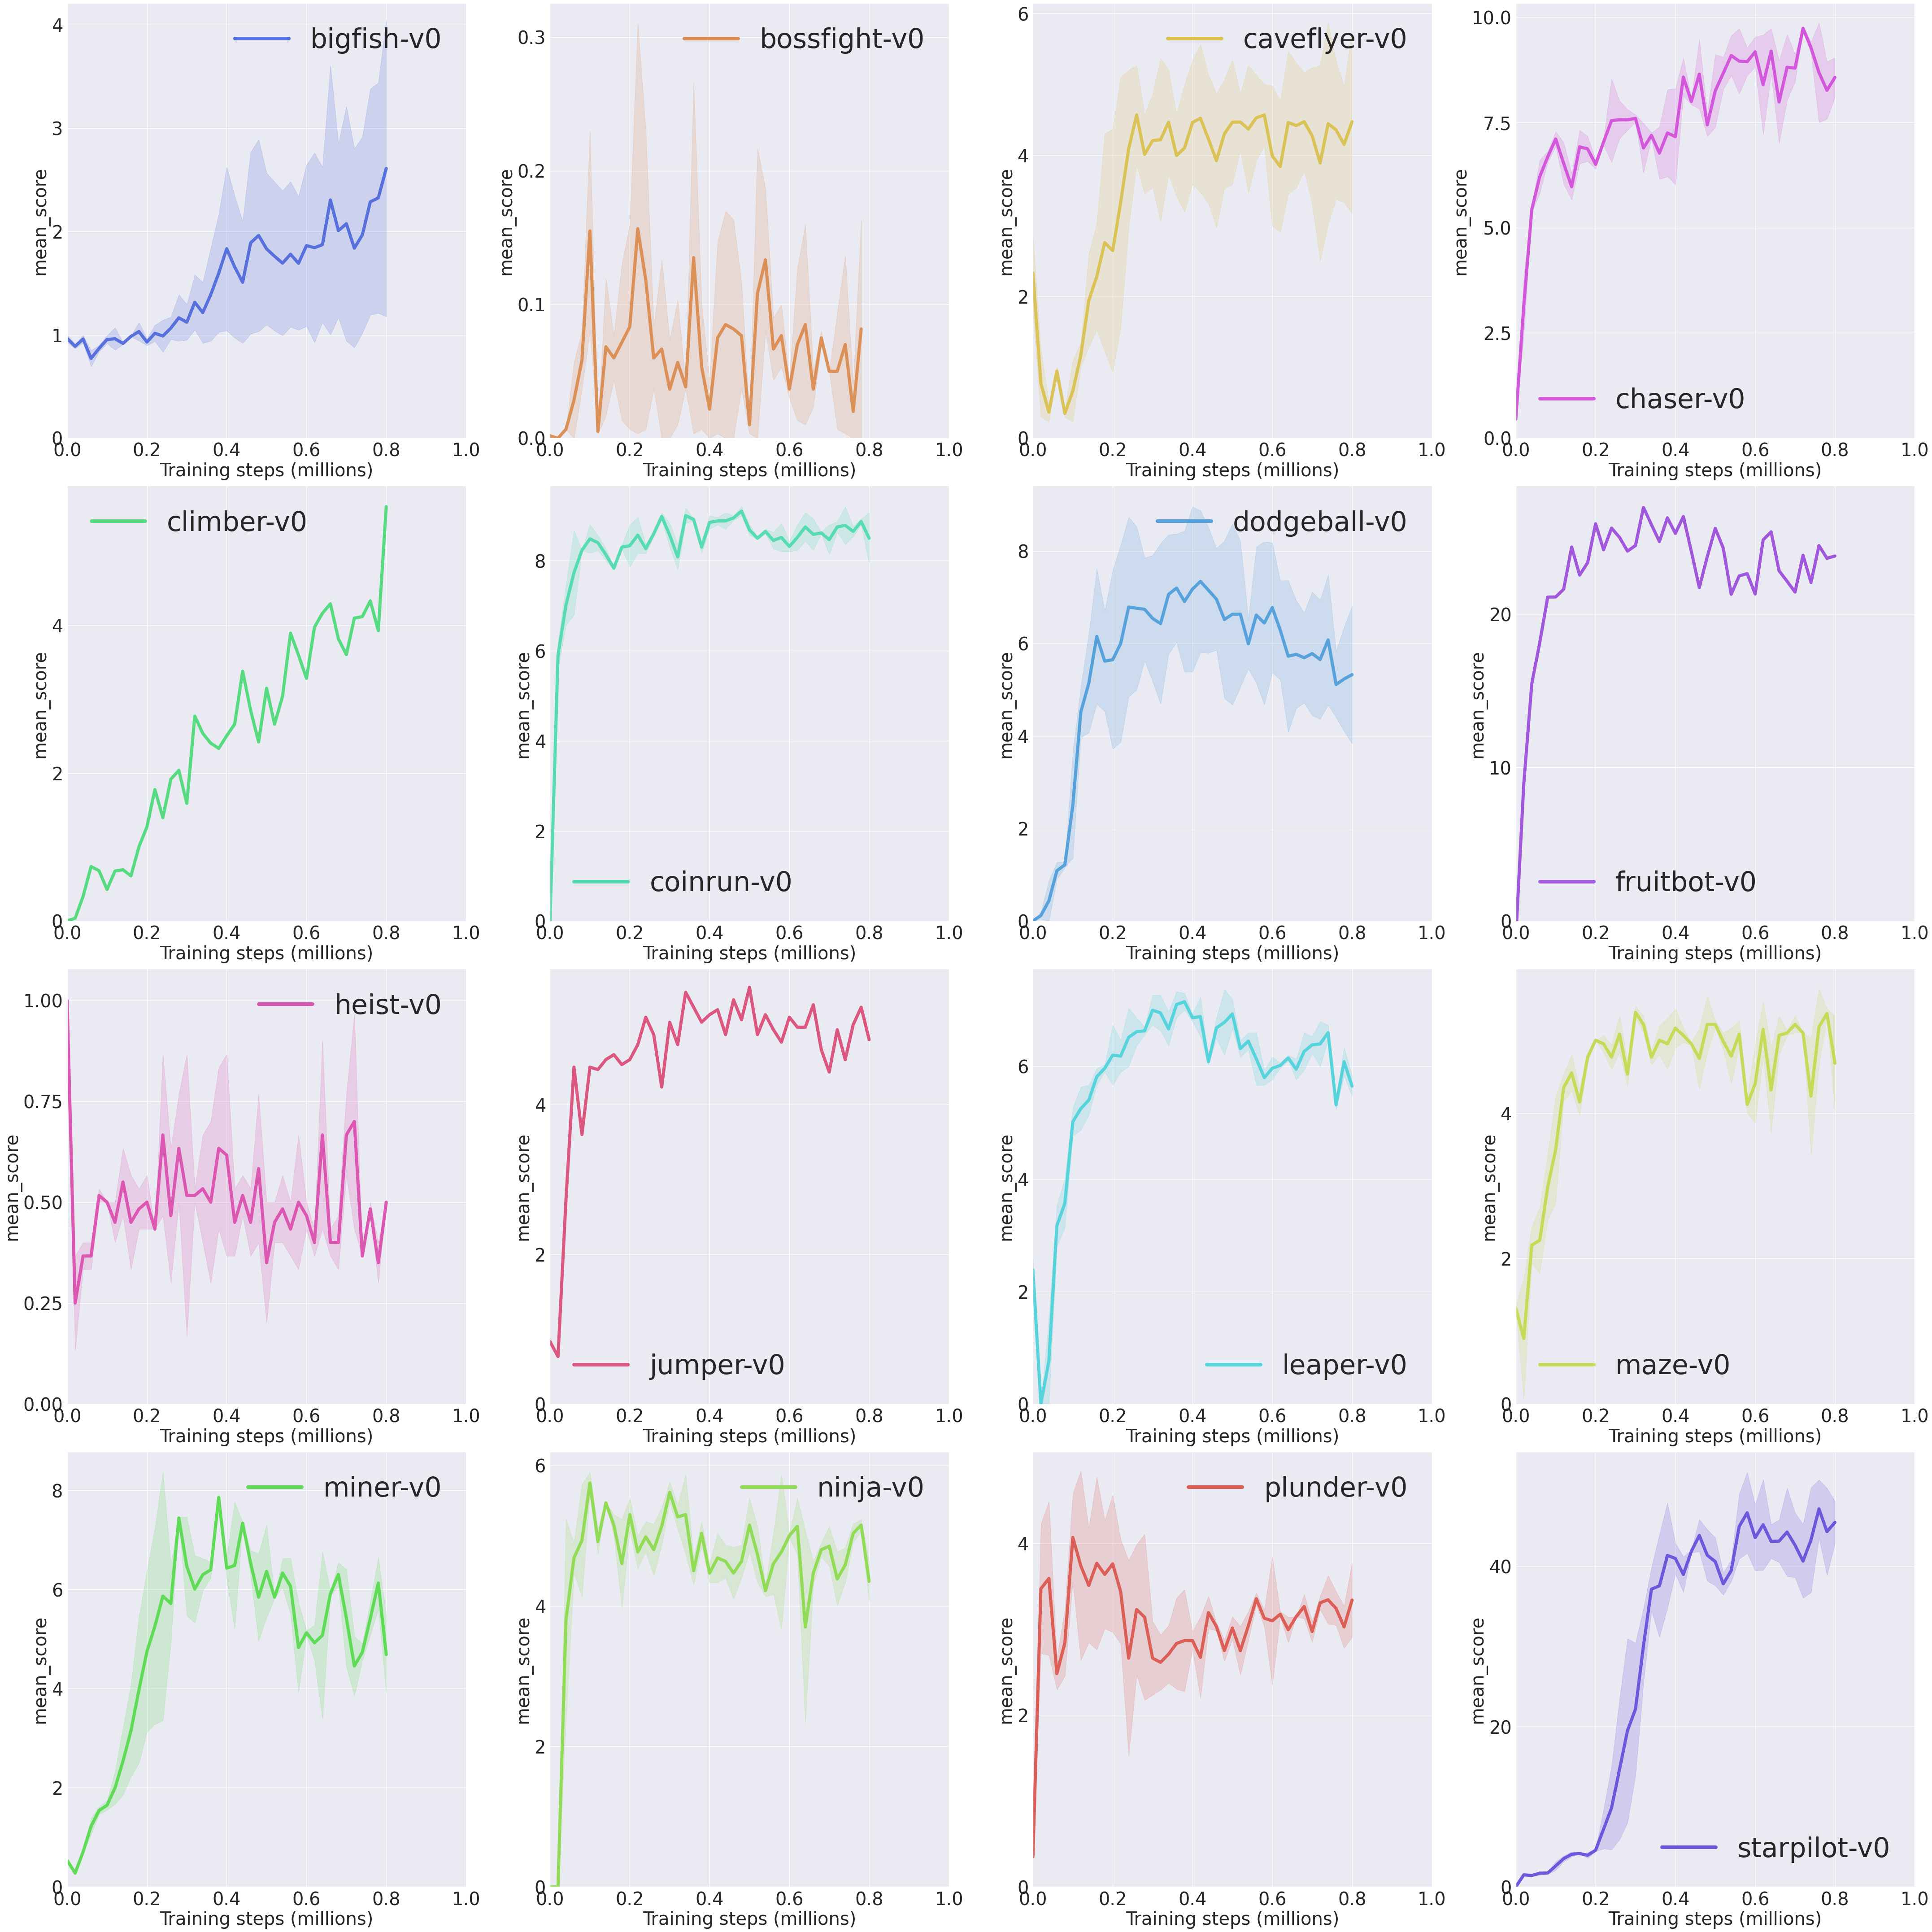

In [155]:
new_labels = {}
for m_id in models_saves.keys():
    if m_id == 'procgen_normalized_scores':
        continue
    #print(m_id.split('procgen-')[1])
    new_labels[m_id] = m_id.split('procgen-')[1]

fig, axs = plt.subplots(4,4, figsize=(60,60))
env_list = ['bigfish','bossfight','caveflyer','chaser','climber','coinrun','dodgeball','fruitbot','heist','jumper','leaper','maze','miner','ninja','plunder','starpilot']

for e_str,ax in zip(env_list,axs.flatten()):
    plot_curves(f"*{e_str}*", _ax=ax, plot_type="shade", allow_different_sizes=False, x_max=1, y_max=None, new_labels=new_labels, leg_size=60, welch=Statistical_tests_enum.NONE,)
    
fig.savefig('graphics/2106adam01campain.png', bbox_inches='tight')

[a-zA-z0-9\-.:]*normalized[a-zA-z0-9\-.:]*
procgen_normalized_scores


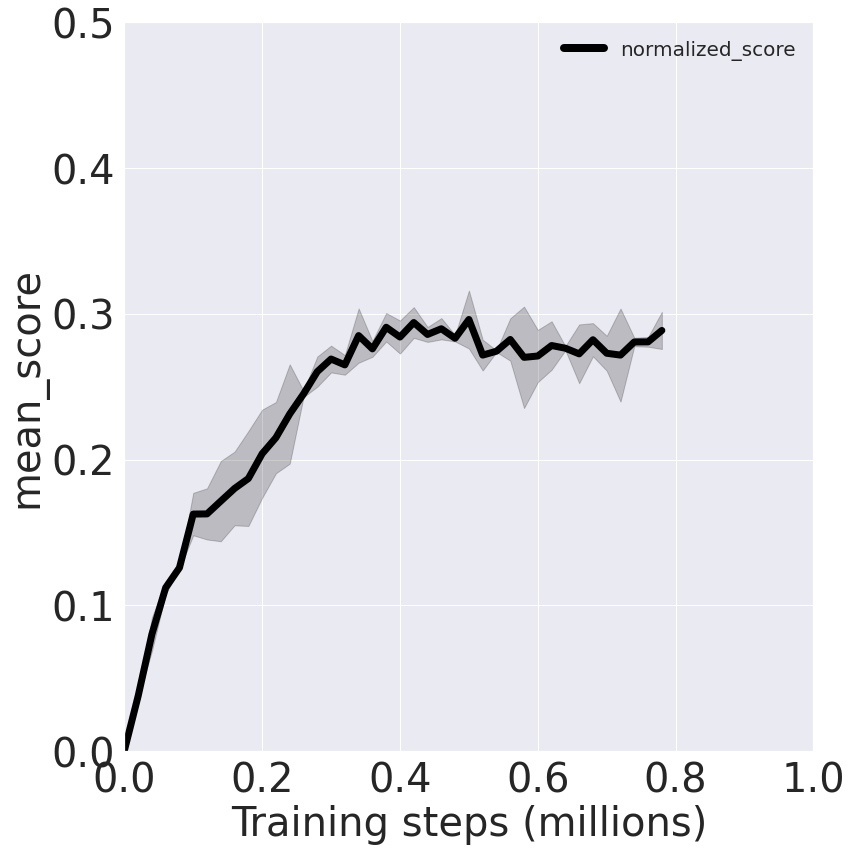

In [169]:
plot_curves("*normalized*", plot_type="shade", allow_different_sizes=False, x_max=1, y_max=0.5, new_labels=None, leg_size=20, welch=Statistical_tests_enum.NONE)

# Create aggregated data with normalized perfs

In [168]:
Rs = namedtuple("Env_Bounds",("rmin rmax"))
#print(Rs.rmin)

procgen_rnorm_dict = {'hard':{'coinrun'  :Rs(5, 10),
                             'starpilot':Rs(1.5, 35),
                             'caveflyer':Rs(2, 13.4),
                             'dodgeball':Rs(1.5, 19),
                             'fruitbot' :Rs(-0.5, 27.2),
                             'chaser'   :Rs(0.5, 14.2),
                             'miner':Rs(1.5, 20),
                             'jumper':Rs(1, 10),
                             'leaper':Rs(1.5, 10),
                             'maze':Rs(4, 10),
                             'bigfish':Rs(0, 40),
                             'heist':Rs(2, 10),
                             'climber':Rs(1, 12.6),
                             'plunder':Rs(3, 30),
                             'ninja':Rs(2, 10),
                             'bossfight':Rs(0.5, 13)},
                      
                      'easy':{'coinrun'  :Rs(5, 10),
                             'starpilot':Rs(2.5, 64),
                             'caveflyer':Rs(3.5, 12),
                             'dodgeball':Rs(1.5, 19),
                             'fruitbot' :Rs(-1.5, 32.4),
                             'chaser'   :Rs(0.5, 13),
                             'miner':Rs(1.5, 13),
                             'jumper':Rs(3, 10),
                             'leaper':Rs(3, 10),
                             'maze':Rs(5, 10),
                             'bigfish':Rs(1, 40),
                             'heist':Rs(3.5, 10),
                             'climber':Rs(2, 12.6),
                             'plunder':Rs(4.5, 30),
                             'ninja':Rs(3.5, 10),
                             'bossfight':Rs(0.5, 13)}}


# Step one retrieve all runs to normalize and aggregate
aggregate_run_name = 'procgen_normalized_scores'
if aggregate_run_name in models_saves.keys():
    del models_saves[aggregate_run_name]
if aggregate_run_name in labels.keys():
    del labels[aggregate_run_name]
if aggregate_run_name in colors.keys():
    del colors[aggregate_run_name]
    
total_training_steps = 780 * 1000  # all seeds must have at least this many training steps done
test_interval = 20000
nb_tests = int((total_training_steps / test_interval) + 1)
nb_seeds = 2
datasets = []
print(f'adding {aggregate_run_name} entry to models_saves, using {nb_seeds} seeds and {nb_tests} test_checkpoints')
for seed in range(nb_seeds):
    print(f'creating normalized data for seed {seed}')
    norm_mean_scores = []
    old_m_id = None
    for i,m_id in enumerate(models_saves.keys()):
        # if 'jumper' in m_id:
        #     m_id = old_m_id # in case we stop there
        #     continue
        print(m_id)
        #print(len(models_saves[m_id]['data'][seed]['test_steps'][:nb_tests]))
        if len(models_saves[m_id]['data']) <= seed:
            print(f"lacking seeds for {m_id}")
            m_id = old_m_id # in case we stop there
            continue
        old_m_id = m_id
        mean_score = np.array(models_saves[m_id]['data'][seed]['mean_score'][:nb_tests])
        diff = models_saves[m_id]['data'][seed]['config']['difficulty']
        #print(diff)
        assert(diff=='easy')

        for env_name in procgen_rnorm_dict[diff].keys():
            if env_name in m_id:
                #print(f"using {env_name} bounds")
                #print(np.interp(mean_score, procgen_rnorm_dict[diff][env_name], (0, 1)))
                norm_mean_scores.append(np.interp(mean_score, procgen_rnorm_dict[diff][env_name], (0, 1)))
    # average results accross environments
    norm_mean_scores = np.mean(norm_mean_scores, axis=0)
    
    # create run dict
    seed_data = {'mean_score': norm_mean_scores, 
                 'test_steps': models_saves[m_id]['data'][seed]['test_steps'][:nb_tests]}  # using last m_id, anyway all the same
    
    datasets.append(seed_data)

# add all run data to aggregate run
models_saves[aggregate_run_name] = {'data':datasets}
labels[aggregate_run_name] = "normalized_score"
colors[aggregate_run_name] = "black"

        #print(mean_score)
        #print(norm_mean_scores)
        
        
#         ys = []
#         nb_seeds = len(runs_data)
#         assert nb_seeds == 3, 'not enough seeds'
#         seeds=[]
#         env_steps = []
#         if nb_seeds > 0:
#             for run in runs_data:
#                 #print()
#                 #print(run['config']['log_interval'])
#                 #print(run.keys())
#                 print(run["config"]["seed"])
#                 data = run[metric]
#                 seeds.append(run["config"]["seed"])
#                 env_steps.append(run['transitions_collected'] / 1000000)
#                 #print(run['transitions_collected'])
#                 ys.append(data)

#         min_len = min([len(y) for y in ys])
#         test_to_log_mult = int(run['config']['test_interval'] / run['config']['log_interval'])
#         min_env_steps = min([e[(min_len-1) * test_to_log_mult] for e in env_steps])
#         train_steps = runs_data[0]['test_steps'][:min_len]

#         ys_same_len = np.ma.empty((len(ys), min_len))
#         ys_same_len.mask = True
#         for i in range(len(ys)):
#             y = ys[i]
#             for j in range(min_len):
#                 ys_same_len[i, j] = y[j]
#         train_steps = [e/1000 for e in train_steps]


#         stds = ys_same_len.std(axis=0)
#         means = ys_same_len.mean(axis=0)


adding procgen_normalized_scores entry to models_saves, using 2 seeds and 40 test_checkpoints
creating normalized data for seed 0
21-06_EffMuz_fstack4_use_adam_lr_0.01_env_procgen:procgen-plunder-v0
21-06_EffMuz_fstack4_use_adam_lr_0.01_env_procgen:procgen-bossfight-v0
21-06_EffMuz_fstack4_use_adam_lr_0.01_env_procgen:procgen-caveflyer-v0
21-06_EffMuz_fstack4_use_adam_lr_0.01_env_procgen:procgen-maze-v0
21-06_EffMuz_fstack4_use_adam_lr_0.01_env_procgen:procgen-ninja-v0
21-06_EffMuz_fstack4_use_adam_lr_0.01_env_procgen:procgen-miner-v0
21-06_EffMuz_fstack4_use_adam_lr_0.01_env_procgen:procgen-climber-v0
21-06_EffMuz_fstack4_use_adam_lr_0.01_env_procgen:procgen-coinrun-v0
21-06_EffMuz_fstack4_use_adam_lr_0.01_env_procgen:procgen-leaper-v0
21-06_EffMuz_fstack4_use_adam_lr_0.01_env_procgen:procgen-dodgeball-v0
21-06_EffMuz_fstack4_use_adam_lr_0.01_env_procgen:procgen-bigfish-v0
21-06_EffMuz_fstack4_use_adam_lr_0.01_env_procgen:procgen-starpilot-v0
21-06_EffMuz_fstack4_use_adam_lr_0.01_env_

In [131]:
print(labels.keys())

odict_keys(['28-05_EffMuzNoCons_fstack8_env_procgen:procgen-ninja-v0', '28-05_EffMuzNoCons_fstack8_env_procgen:procgen-plunder-v0'])


In [115]:
a = np.


TypeError: 'float' object is not callable